In [1]:
import optuna
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import umap
from sklearn.preprocessing import StandardScaler

In [2]:
plt.rcParams["font.size"] = 20
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["axes.titlesize"] = 20
plt.rcParams["font.family"] = "IPAexGothic"  #'Times New Roman'

In [3]:
data = pd.read_csv('../input/tsta_a_1791676_sm7407.csv')
data

,ID,X,n,Fe (wt%),Mn (wt%),Si (wt%),Al (wt%),Mg (wt%),Ti (wt%),Cu (wt%),Cr (wt%),Zn (wt%),2% proof stress (Mpa),Tensile strength (Mpa),Elongation (%)
0,A 5005 P,1,2,0.35,0.1,0.15,98.33,0.8,0.0,0.1,0.05,0.125,95,125,2
1,A 5005 P,1,4,0.35,0.1,0.15,98.33,0.8,0.0,0.1,0.05,0.125,120,145,2
2,A 5005 P,1,6,0.35,0.1,0.15,98.33,0.8,0.0,0.1,0.05,0.125,145,165,2
3,A 5005 P,1,8,0.35,0.1,0.15,98.33,0.8,0.0,0.1,0.05,0.125,165,185,2
4,A 5005 P,2,2,0.35,0.1,0.15,98.33,0.8,0.0,0.1,0.05,0.125,85,120,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,A 5N01 P,1,4,0.13,0.1,0.08,99.19,0.4,0.0,0.1,0.00,0.015,115,125,3
111,A 5N01 P,1,6,0.13,0.1,0.08,99.19,0.4,0.0,0.1,0.00,0.015,135,145,2
112,A 5N01 P,3,2,0.13,0.1,0.08,99.19,0.4,0.0,0.1,0.00,0.015,85,120,4
113,A 5N01 P,3,4,0.13,0.1,0.08,99.19,0.4,0.0,0.1,0.00,0.015,105,140,3


In [4]:
correlation = data[["2% proof stress (Mpa)", "Tensile strength (Mpa)", "Elongation (%)"]].corr()
correlation

,2% proof stress (Mpa),Tensile strength (Mpa),Elongation (%)
2% proof stress (Mpa),1.000000,0.906414,-0.390692
Tensile strength (Mpa),0.906414,1.000000,-0.081633
Elongation (%),-0.390692,-0.081633,1.000000


In [5]:
params_elongation = {
    "objective": "regression",
    "learning_rate": 0.01,
    "reg_alpha": 0.1,
    "reg_lambda": 0.1,
    "random_state":42,
    "max_depth": 5,
    "n_estimators": 1000, 
    "colsample_bytree": 0.7,
    "min_data_in_leaf": 5 #パラメータを調整
}

In [6]:
params_proof_stress = {
    "objective": "regression",
    "learning_rate": 0.01,
    "reg_alpha": 0.1,
    "reg_lambda": 0.1,
    "random_state":42,
    "max_depth": 5,
    "n_estimators": 1000, 
    "colsample_bytree": 0.7,
}

In [7]:
# 説明変数と目的変数
wt_columns = [col for col in data.columns if '(wt%)' in col]
additional_features = ['X', 'n']
all_features = wt_columns + additional_features
X = data[all_features]
y_elongation = data["Elongation (%)"]
y_proof_stress = data["2% proof stress (Mpa)"]

# トレーニングとテストデータに分割
X_train, X_test, y_train_elongation, y_test_elongation = train_test_split(
    X, y_elongation, test_size=0.2, random_state=42
)
_, _, y_train_proof_stress, y_test_proof_stress = train_test_split(
    X, y_proof_stress, test_size=0.2, random_state=42
)

# 学習データ用LightGBMモデルのトレーニング
model_elongation = lgb.LGBMRegressor(**params_elongation)
model_proof_stress = lgb.LGBMRegressor(**params_proof_stress)

model_elongation.fit(X_train, y_train_elongation)
model_proof_stress.fit(X_train, y_train_proof_stress)

# テストデータでの予測値
y_pred_elongation = model_elongation.predict(X_test)
y_pred_proof_stress = model_proof_stress.predict(X_test)

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


In [8]:
# 指標計算関数
def calculate_metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    return r2, rmse, mae

# Elongation (%) の評価指標
r2_elongation, rmse_elongation, mae_elongation = calculate_metrics(y_test_elongation, y_pred_elongation)

# 2% proof stress (Mpa) の評価指標
r2_proof_stress, rmse_proof_stress, mae_proof_stress = calculate_metrics(y_test_proof_stress, y_pred_proof_stress)

Text(0.5, 1.0, 'Elongation (%) - Prediction vs Actual\n')

findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.


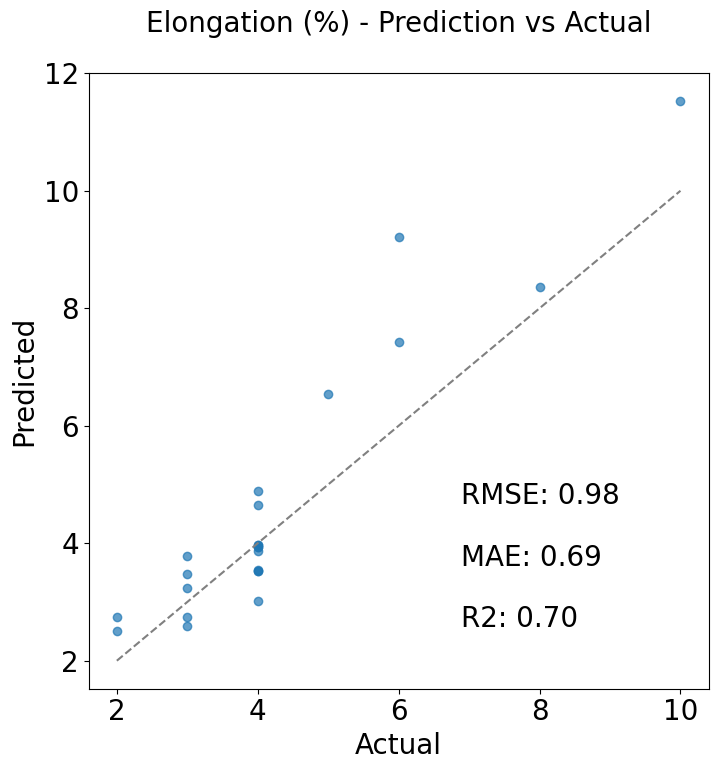

In [9]:
## Elongation (%) のプロット
plt.figure(figsize=(8, 8))
plt.scatter(y_test_elongation, y_pred_elongation, alpha=0.7)
plt.plot(
    [y_test_elongation.min(), y_test_elongation.max()],
    [y_test_elongation.min(), y_test_elongation.max()],
    '--',
    color="gray",
    label="truth"
)
plt.text(
        0.6, 0.3, f"RMSE: {rmse_elongation:.2f}", transform=plt.gca().transAxes
    )
plt.text(
    0.6, 0.2, f"MAE: {mae_elongation:.2f}", transform=plt.gca().transAxes
)
plt.text(0.6, 0.1, f"R2: {r2_elongation:.2f}", transform=plt.gca().transAxes)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Elongation (%) - Prediction vs Actual\n')

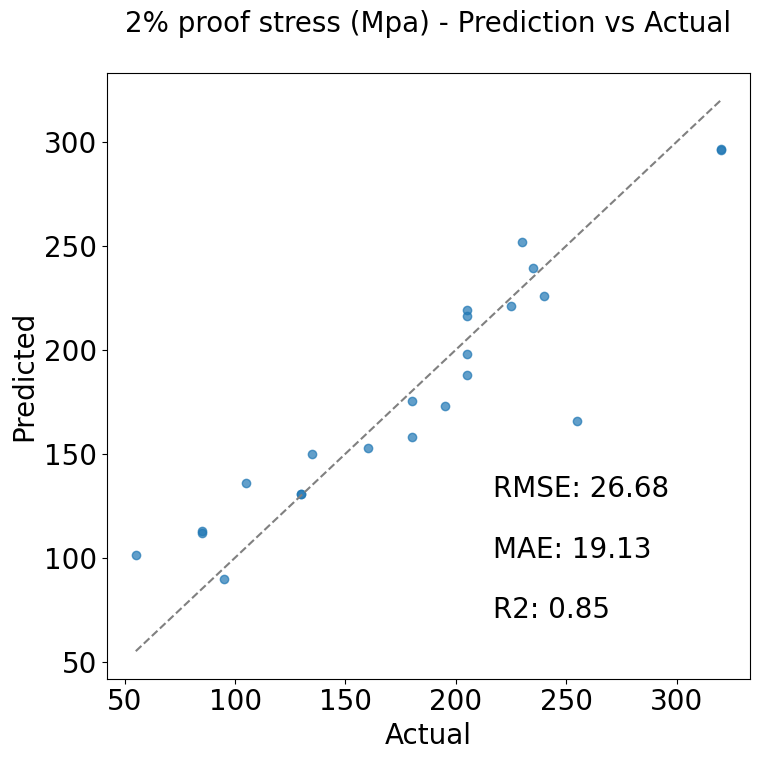

In [10]:
# 2% proof stress (Mpa) のプロット
plt.figure(figsize=(8, 8))
plt.scatter(y_test_proof_stress, y_pred_proof_stress, alpha=0.7)
plt.plot(
    [y_test_proof_stress.min(), y_test_proof_stress.max()],
    [y_test_proof_stress.min(), y_test_proof_stress.max()],
    '--',
    color="gray",
    label="truth"
)

plt.text(
        0.6, 0.3, f"RMSE: {rmse_proof_stress:.2f}", transform=plt.gca().transAxes
    )
plt.text(
    0.6, 0.2, f"MAE: {mae_proof_stress:.2f}", transform=plt.gca().transAxes
)
plt.text(0.6, 0.1, f"R2: {r2_proof_stress:.2f}", transform=plt.gca().transAxes)

plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'2% proof stress (Mpa) - Prediction vs Actual\n')

plt.tight_layout()
plt.show()

In [11]:
# Optuna内で使用する全データ学習モデル
model_full_elongation = lgb.LGBMRegressor(**params_elongation)
model_full_proof_stress = lgb.LGBMRegressor(**params_proof_stress)

model_full_elongation.fit(X, y_elongation)
model_full_proof_stress.fit(X, y_proof_stress)

# データ全体での目的変数の範囲を取得
elongation_min, elongation_max = y_elongation.min(), y_elongation.max()
proof_stress_min, proof_stress_max = y_proof_stress.min(), y_proof_stress.max()

# 試行結果を記録するためのリスト
trial_results = []

def objective(trial):
    # wt%列の試行値をサンプリング
    proportions = {
        col: trial.suggest_float(col, X[col].min(), X[col].max())
        for col in wt_columns
    }
    # 合計が100になるよう正規化
    total = sum(proportions.values())
    normalized_proportions = {col: (value / total) * 100 for col, value in proportions.items()}
    
    # normalized_proportionsを小数点2桁に
    normalized_proportions = {col: round(value, 2) for col, value in normalized_proportions.items()}

    # Xとnの試行値を整数型でサンプリング
    additional_values = {
        'X': trial.suggest_int('X', int(X['X'].min()), int(X['X'].max())),
        'n': trial.suggest_int('n', int(X['n'].min()), int(X['n'].max()))
    }
    
    # サンプルデータ作成
    input_data = pd.DataFrame([{**normalized_proportions, **additional_values}])

    # 予測値の計算（全データ学習モデルを使用）
    pred_elongation = model_full_elongation.predict(input_data)[0]
    pred_proof_stress = model_full_proof_stress.predict(input_data)[0]

    # 制約条件をチェック
    if pred_elongation < 15 or pred_proof_stress < 130:
        return -1e6  # 制約を満たさない場合、非常に低いスコアを返す

    # 正規化（0～1）
    norm_elongation = (pred_elongation - elongation_min) / (elongation_max - elongation_min)
    norm_proof_stress = (pred_proof_stress - proof_stress_min) / (proof_stress_max - proof_stress_min)
    
    # スコアの計算（正規化後の加重和）
    score = 0.5 * norm_elongation + 0.5 * norm_proof_stress

    # 試行結果を記録
    trial_results.append({
        **normalized_proportions,
        **additional_values,
        "Predicted Elongation (%)": pred_elongation,
        "Predicted 2% proof stress (Mpa)": pred_proof_stress,
        "Score": score
    })

    return score


# Optunaで最適化
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=1000)


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


[I 2024-12-05 13:02:11,743] A new study created in memory with name: no-name-384a4340-85dc-40bc-91e9-380a768afb38
[I 2024-12-05 13:02:11,754] Trial 0 finished with value: -1000000.0 and parameters: {'Fe (wt%)': 0.21239882614641975, 'Mn (wt%)': 0.713528586743338, 'Si (wt%)': 0.1897990912717108, 'Al (wt%)': 97.20737291193336, 'Mg (wt%)': 1.1254866780573298, 'Ti (wt%)': 0.015599452033620266, 'Cu (wt%)': 0.024646688973455958, 'Cr (wt%)': 0.2165440364437338, 'Zn (wt%)': 0.08112265129175297, 'X': 3, 'n': 1}. Best is trial 0 with value: -1000000.0.
[I 2024-12-05 13:02:11,766] Trial 1 finished with value: -1000000.0 and parameters: {'Fe (wt%)': 0.3433801674756387, 'Mn (wt%)': 0.6260075541923121, 'Si (wt%)': 0.11185086660174143, 'Al (wt%)': 95.14821533800307, 'Mg (wt%)': 1.2528309708184673, 'Ti (wt%)': 0.030424224295953775, 'Cu (wt%)': 0.061980514530579026, 'Cr (wt%)': 0.10798625466052894, 'Zn (wt%)': 0.04703520542178461, 'X': 3, 'n': 2}. Best is trial 0 with value: -1000000.0.
[I 2024-12-05 13

In [12]:
results_df = pd.DataFrame(trial_results)
results_df

,Fe (wt%),Mn (wt%),Si (wt%),Al (wt%),Mg (wt%),Ti (wt%),Cu (wt%),Cr (wt%),Zn (wt%),X,n,Predicted Elongation (%),Predicted 2% proof stress (Mpa),Score
0,0.19,0.34,0.14,95.40,3.53,0.05,0.07,0.19,0.08,1,1,15.701608,177.680174,0.633515
1,0.18,0.73,0.14,95.09,3.46,0.05,0.07,0.19,0.07,1,1,15.086764,177.680174,0.615432
2,0.18,0.71,0.14,94.93,3.64,0.05,0.07,0.20,0.08,1,1,15.086764,177.680174,0.615432
3,0.18,0.70,0.14,94.90,3.69,0.06,0.07,0.19,0.07,1,1,15.086764,177.680174,0.615432
4,0.18,0.70,0.14,94.90,3.69,0.06,0.07,0.19,0.07,1,1,15.086764,177.680174,0.615432
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
511,0.24,0.37,0.20,94.80,4.07,0.03,0.04,0.13,0.11,1,1,15.322049,191.659814,0.645269
512,0.24,0.34,0.19,94.92,3.99,0.03,0.05,0.11,0.12,1,1,15.322049,191.659814,0.645269
513,0.23,0.33,0.20,94.81,4.11,0.04,0.05,0.12,0.11,1,1,15.322049,191.659814,0.645269
514,0.24,0.32,0.20,94.93,3.98,0.03,0.05,0.13,0.12,1,1,15.007031,191.659814,0.636004


In [13]:
# 重複を削除
results_df = results_df.drop_duplicates()
results_df

,Fe (wt%),Mn (wt%),Si (wt%),Al (wt%),Mg (wt%),Ti (wt%),Cu (wt%),Cr (wt%),Zn (wt%),X,n,Predicted Elongation (%),Predicted 2% proof stress (Mpa),Score
0,0.19,0.34,0.14,95.40,3.53,0.05,0.07,0.19,0.08,1,1,15.701608,177.680174,0.633515
1,0.18,0.73,0.14,95.09,3.46,0.05,0.07,0.19,0.07,1,1,15.086764,177.680174,0.615432
2,0.18,0.71,0.14,94.93,3.64,0.05,0.07,0.20,0.08,1,1,15.086764,177.680174,0.615432
3,0.18,0.70,0.14,94.90,3.69,0.06,0.07,0.19,0.07,1,1,15.086764,177.680174,0.615432
5,0.18,0.70,0.14,95.02,3.58,0.06,0.07,0.20,0.07,1,1,15.086764,177.680174,0.615432
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
511,0.24,0.37,0.20,94.80,4.07,0.03,0.04,0.13,0.11,1,1,15.322049,191.659814,0.645269
512,0.24,0.34,0.19,94.92,3.99,0.03,0.05,0.11,0.12,1,1,15.322049,191.659814,0.645269
513,0.23,0.33,0.20,94.81,4.11,0.04,0.05,0.12,0.11,1,1,15.322049,191.659814,0.645269
514,0.24,0.32,0.20,94.93,3.98,0.03,0.05,0.13,0.12,1,1,15.007031,191.659814,0.636004


In [14]:
# Scoreの高い順にソート
results_df.sort_values("Score", ascending=False, inplace=True)
results_df


/var/folders/3q/gwgy4r2561v6xx__yjlk15b80000gn/T/ipykernel_14457/836108709.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df.sort_values("Score", ascending=False, inplace=True)


,Fe (wt%),Mn (wt%),Si (wt%),Al (wt%),Mg (wt%),Ti (wt%),Cu (wt%),Cr (wt%),Zn (wt%),X,n,Predicted Elongation (%),Predicted 2% proof stress (Mpa),Score
416,0.17,0.37,0.16,94.78,4.19,0.04,0.06,0.13,0.10,1,1,15.632039,193.152526,0.656834
418,0.18,0.36,0.16,94.89,4.10,0.04,0.06,0.10,0.11,1,1,15.632039,192.008635,0.654958
419,0.19,0.34,0.17,94.81,4.20,0.04,0.06,0.08,0.11,1,1,15.632039,192.008635,0.654958
420,0.19,0.34,0.17,94.84,4.17,0.04,0.06,0.09,0.11,1,1,15.632039,192.008635,0.654958
440,0.19,0.35,0.17,94.86,4.13,0.04,0.05,0.09,0.12,1,1,15.632039,192.008635,0.654958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40,0.17,0.69,0.14,95.01,3.59,0.06,0.07,0.20,0.07,1,1,15.086764,177.680174,0.615432
42,0.17,0.67,0.13,94.82,3.81,0.05,0.08,0.19,0.07,1,1,15.086764,177.680174,0.615432
43,0.18,0.69,0.14,95.07,3.52,0.06,0.07,0.19,0.07,1,1,15.086764,177.680174,0.615432
44,0.17,0.70,0.13,94.89,3.71,0.06,0.07,0.18,0.07,1,1,15.086764,177.680174,0.615432


In [15]:
results_df[:10]

,Fe (wt%),Mn (wt%),Si (wt%),Al (wt%),Mg (wt%),Ti (wt%),Cu (wt%),Cr (wt%),Zn (wt%),X,n,Predicted Elongation (%),Predicted 2% proof stress (Mpa),Score
416,0.17,0.37,0.16,94.78,4.19,0.04,0.06,0.13,0.10,1,1,15.632039,193.152526,0.656834
418,0.18,0.36,0.16,94.89,4.10,0.04,0.06,0.10,0.11,1,1,15.632039,192.008635,0.654958
419,0.19,0.34,0.17,94.81,4.20,0.04,0.06,0.08,0.11,1,1,15.632039,192.008635,0.654958
420,0.19,0.34,0.17,94.84,4.17,0.04,0.06,0.09,0.11,1,1,15.632039,192.008635,0.654958
440,0.19,0.35,0.17,94.86,4.13,0.04,0.05,0.09,0.12,1,1,15.632039,192.008635,0.654958
441,0.19,0.35,0.17,94.89,4.10,0.04,0.05,0.09,0.12,1,1,15.632039,192.008635,0.654958
442,0.19,0.36,0.17,94.86,4.12,0.04,0.04,0.09,0.12,1,1,15.632039,192.008635,0.654958
434,0.19,0.35,0.18,94.78,4.22,0.04,0.05,0.07,0.11,1,1,15.632039,191.260091,0.653731
426,0.19,0.34,0.18,94.82,4.17,0.04,0.05,0.09,0.11,1,1,15.632039,191.260091,0.653731
459,0.23,0.33,0.20,94.86,4.06,0.04,0.05,0.13,0.12,1,1,15.322049,191.659814,0.645269


/Users/takaharawataru/anaconda3/envs/local/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


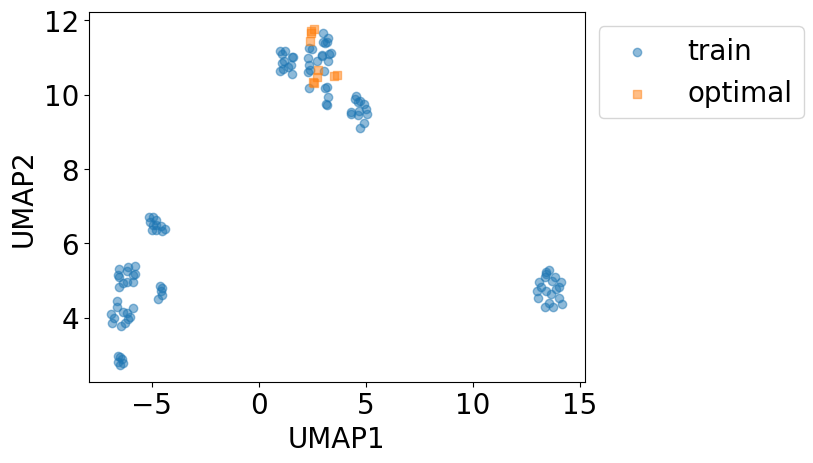

In [16]:
scaler_x = StandardScaler()
scaler_x.fit(X)

X_train = scaler_x.transform(X)
X_test = scaler_x.transform(results_df[all_features][:10])

umap_ = umap.UMAP(
    n_components=2, random_state=42, n_neighbors=15
)  # n_neighborsのデフォルト値は15

result_umap = umap_.fit(X_train)
X_train_umap = result_umap.transform(X_train)
X_test_umap = result_umap.transform(X_test)

train_umap_df = pd.DataFrame(X_train_umap, columns=["UMAP1", "UMAP2"])
test_umap_df = pd.DataFrame(X_test_umap, columns=["UMAP1", "UMAP2"])

plt.scatter(train_umap_df["UMAP1"], train_umap_df["UMAP2"], alpha=0.5)
plt.scatter(test_umap_df["UMAP1"], test_umap_df["UMAP2"], marker="s",alpha=0.5)
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.legend(["train", "optimal", "multi-obtimal"], bbox_to_anchor=(1, 1))
plt.show()

In [17]:
# 試行結果を記録するためのリスト
trial_results_multi = []

def objective_multi(trial):
    # wt%列の試行値をサンプリング
    proportions = {
        col: trial.suggest_float(col, X[col].min(), X[col].max())
        for col in wt_columns
    }
    # 合計が100になるよう正規化
    total = sum(proportions.values())
    normalized_proportions = {col: (value / total) * 100 for col, value in proportions.items()}
    
    # normalized_proportionsを小数点2桁に
    normalized_proportions = {col: round(value, 2) for col, value in normalized_proportions.items()}

    # Xとnの試行値を整数型でサンプリング
    additional_values = {
        'X': trial.suggest_int('X', int(X['X'].min()), int(X['X'].max())),
        'n': trial.suggest_int('n', int(X['n'].min()), int(X['n'].max()))
    }
    
    # サンプルデータ作成
    input_data = pd.DataFrame([{**normalized_proportions, **additional_values}])

    # 予測値の計算（全データ学習モデルを使用）
    pred_elongation = model_full_elongation.predict(input_data)[0]
    pred_proof_stress = model_full_proof_stress.predict(input_data)[0]

    # 制約条件をチェック
    if pred_elongation < 15 or pred_proof_stress < 130:
        return -1e6  # 制約を満たさない場合、非常に低いスコアを返す
    
    # 試行結果を記録
    trial_results_multi.append({
        **normalized_proportions,
        **additional_values,
        "Predicted Elongation (%)": pred_elongation,
        "Predicted 2% proof stress (Mpa)": pred_proof_stress
    })
    
    return pred_elongation, pred_proof_stress

# Optunaで多目的最適化
sampler_multi = optuna.samplers.TPESampler(seed=42)
study_multi = optuna.create_study(directions=["maximize", "maximize"], sampler=sampler_multi)
study_multi.optimize(objective_multi, n_trials=1000)

[I 2024-12-05 13:05:33,598] A new study created in memory with name: no-name-8fae56c7-31ab-443e-963c-46ed3e6c051a


[W 2024-12-05 13:05:33,638] Trial 0 failed with parameters: {'Fe (wt%)': 0.21239882614641975, 'Mn (wt%)': 0.713528586743338, 'Si (wt%)': 0.1897990912717108, 'Al (wt%)': 97.20737291193336, 'Mg (wt%)': 1.1254866780573298, 'Ti (wt%)': 0.015599452033620266, 'Cu (wt%)': 0.024646688973455958, 'Cr (wt%)': 0.2165440364437338, 'Zn (wt%)': 0.08112265129175297, 'X': 3, 'n': 1} because of the following error: The number of the values 1 did not match the number of the objectives 2.
[W 2024-12-05 13:05:33,647] Trial 0 failed with value -1000000.0.
[W 2024-12-05 13:05:33,672] Trial 1 failed with parameters: {'Fe (wt%)': 0.3433801674756387, 'Mn (wt%)': 0.6260075541923121, 'Si (wt%)': 0.11185086660174143, 'Al (wt%)': 95.14821533800307, 'Mg (wt%)': 1.2528309708184673, 'Ti (wt%)': 0.030424224295953775, 'Cu (wt%)': 0.061980514530579026, 'Cr (wt%)': 0.10798625466052894, 'Zn (wt%)': 0.04703520542178461, 'X': 3, 'n': 2} because of the following error: The number of the values 1 did not match the number of th

In [18]:
results_multi_df = pd.DataFrame(trial_results_multi)
results_multi_df

,Fe (wt%),Mn (wt%),Si (wt%),Al (wt%),Mg (wt%),Ti (wt%),Cu (wt%),Cr (wt%),Zn (wt%),X,n,Predicted Elongation (%),Predicted 2% proof stress (Mpa)
0,0.13,0.19,0.11,95.14,4.13,0.03,0.04,0.13,0.11,1,1,15.033434,205.593036


In [19]:
# 正規化（0～1）
norm_elongation_multi = (results_multi_df['Predicted Elongation (%)'] - elongation_min) / (elongation_max - elongation_min)
norm_proof_stress_multi = (results_multi_df['Predicted 2% proof stress (Mpa)'] - proof_stress_min) / (proof_stress_max - proof_stress_min)

# スコアの計算（正規化後の加重和）
score_multi = 0.5 * norm_elongation_multi + 0.5 * norm_proof_stress_multi
print(score_multi)

0    0.659622
dtype: float64


In [20]:
results_multi_df["Score"] = score_multi
results_multi_df

,Fe (wt%),Mn (wt%),Si (wt%),Al (wt%),Mg (wt%),Ti (wt%),Cu (wt%),Cr (wt%),Zn (wt%),X,n,Predicted Elongation (%),Predicted 2% proof stress (Mpa),Score
0,0.13,0.19,0.11,95.14,4.13,0.03,0.04,0.13,0.11,1,1,15.033434,205.593036,0.659622


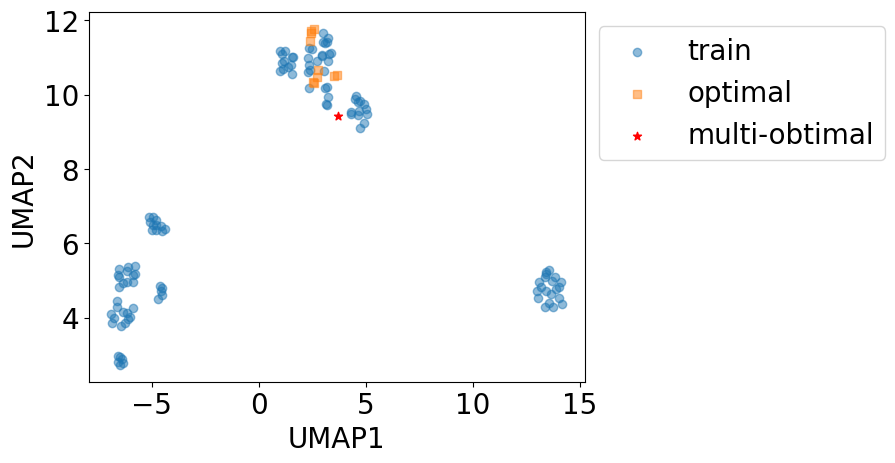

In [21]:
X_test_multi = scaler_x.transform(results_multi_df[all_features])
X_test_umap_multi = result_umap.transform(X_test_multi)

test_umap_multi_df = pd.DataFrame(X_test_umap_multi, columns=["UMAP1", "UMAP2"])

plt.scatter(train_umap_df["UMAP1"], train_umap_df["UMAP2"], alpha=0.5)
plt.scatter(test_umap_df["UMAP1"], test_umap_df["UMAP2"], marker="s",alpha=0.5)
plt.scatter(test_umap_multi_df["UMAP1"], test_umap_multi_df["UMAP2"], marker="*", color="red")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.legend(["train", "optimal", "multi-obtimal"], bbox_to_anchor=(1, 1))
plt.show()